### 기본 세팅

In [1]:
import os
import shutil
import pandas as pd
from sklearn.utils import shuffle
import numpy as np

# 상수 정의
SEED = 42  # 무작위 셔플링을 위한 시드 값
DATA_ROOT = './dataset'  # 데이터셋의 루트 경로
DATASET_FOLDERS = [
    'Moon_jellyfish',
    'barrel_jellyfish',
    'blue_jellyfish',
    'compass_jellyfish',
    'lions_mane_jellyfish',
    'mauve_stinger_jellyfish',
]

# 이미지 경로를 포함하는 리스트를 생성하는 함수 정의
def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path

# 이미지 파일을 이동시키는 함수 정의
def move_images(src_dir, dest_dir, sub_folders):
    for folder in sub_folders:
        src_folder_path = os.path.join(src_dir, folder)
        dest_folder_path = os.path.join(dest_dir, folder)
        if not os.path.exists(dest_folder_path):
            os.makedirs(dest_folder_path)
        for file in os.listdir(src_folder_path):
            shutil.move(os.path.join(src_folder_path, file), dest_folder_path)

# 이미지 경로 리스트를 생성하는 함수 정의
def create_images_list_for_all_folders(root_path, sub_folders):
    images_list = []
    for folder in sub_folders:
        folder_path = os.path.join(root_path, folder)
        images = create_images_list(folder_path)
        images_list.extend([(img_path, folder) for img_path in images])
    return images_list

### 1단계: add_dataset_1 폴더의 이미지들을 원본 데이터셋의 적절한 폴더로 이동

In [2]:
for folder in ['train', 'test', 'valid']:
    move_images(os.path.join(DATA_ROOT, 'add_dataset_1', folder),
                os.path.join(DATA_ROOT, 'Train_Test_Valid', folder.capitalize()),
                DATASET_FOLDERS)

### 2단계: add_dataset_2 폴더의 데이터를 add_dataset_3 폴더로 이동하여 병합

In [3]:
move_images(os.path.join(DATA_ROOT, 'add_dataset_2'),
            os.path.join(DATA_ROOT, 'add_dataset_3'),
            ['barrel_jellyfish', 'mauve_stinger_jellyfish'])

### 3단계: 병합된 데이터로 데이터셋 만들기

In [4]:
merged_data_path = os.path.join(DATA_ROOT, 'add_dataset_3')

# 각 클래스에 대한 이미지 경로 리스트를 생성
all_images_list = create_images_list_for_all_folders(merged_data_path, DATASET_FOLDERS)

# 이미지 경로와 라벨을 포함하는 데이터프레임 생성
data_df = pd.DataFrame(all_images_list, columns=['img', 'label'])

# 데이터프레임을 무작위로 섞고 인덱스를 재설정
data_df = shuffle(data_df, random_state=SEED).reset_index(drop=True)

# 데이터를 학습(train), 검증(valid), 테스트(test) 세트로 분할
total_size = len(data_df)
train_size = int(total_size * 0.75)
valid_size = int(total_size * 0.15)

train_df = data_df[:train_size].reset_index(drop=True)
valid_df = data_df[train_size:train_size + valid_size].reset_index(drop=True)
test_df = data_df[train_size + valid_size:].reset_index(drop=True)

### 4단계 : 병합된 데이터를 저장하고 원본 데이터 폴더로 이동해 최종 병합

In [5]:
MERGED_ROOT = './dataset/merged_df'  # Merged 데이터셋의 루트 경로

# 데이터프레임에 있는 모든 이미지를 merged_df 폴더에 복사
def copy_images_to_merged(df, src_root, dest_root):
    for _, row in df.iterrows():
        src_path = row['img']
        dest_path = os.path.join(dest_root, row['label'], os.path.basename(row['img']))
        dest_folder_path = os.path.dirname(dest_path)
        if not os.path.exists(dest_folder_path):
            os.makedirs(dest_folder_path)
        shutil.copy(src_path, dest_path)

# 이미지를 복사하는 함수를 호출하여 이미지를 복사
copy_images_to_merged(data_df, DATA_ROOT, MERGED_ROOT)


# 이미지를 이동하는 함수 정의
def move_images_to_ttv(df, src_root, dest_root):
    for _, row in df.iterrows():
        src_path = os.path.join(src_root, row['label'], os.path.basename(row['img']))
        dest_path = os.path.join(dest_root, row['label'], os.path.basename(row['img']))
        dest_folder_path = os.path.dirname(dest_path)
        if not os.path.exists(dest_folder_path):
            os.makedirs(dest_folder_path)
        shutil.move(src_path, dest_path)

# 이미지를 이동하는 함수를 호출하여 이미지를 이동
for df, folder in zip([train_df, valid_df, test_df], ['Train', 'valid', 'test']):
    move_images_to_ttv(df, MERGED_ROOT, os.path.join(DATA_ROOT, 'Train_Test_Valid', folder))

## 최종 데이터셋 확인

In [7]:
# 필요한 라이브러리 임포트
from sklearn.preprocessing import LabelEncoder  # LabelEncoder를 사용하기 위해 임포트
from sklearn.model_selection import train_test_split  # train_test_split을 사용하기 위해 임포트
import os  # 파일 및 디렉토리 관리를 위해 임포트
import cv2  # OpenCV 라이브러리를 사용하기 위해 임포트
import numpy as np  # 배열 및 행렬 작업을 위해 임포트
import matplotlib.pyplot as plt  # 데이터 시각화를 위해 임포트
import seaborn as sns  # 시각화를 위해 Seaborn 라이브러리 임포트

# 데이터 로드 함수 정의
def load_data(data_directory):
    images = []  # 이미지 데이터를 저장할 리스트
    labels = []  # 레이블 데이터를 저장할 리스트
    classes = []  # 클래스 목록을 저장할 리스트
    label_encoder = LabelEncoder()  # LabelEncoder 객체 생성

    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name)
        if os.path.isdir(class_path):  # 디렉토리인 경우에만 처리
            classes.append(class_name)

            for filename in os.listdir(class_path):
                filepath = os.path.join(class_path, filename)
                img = cv2.imread(filepath)  # 이미지 파일 읽기
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # RGB로 변환
                    img = cv2.resize(img, (224, 224))  # 크기 조정
                    img = img / 255.0  # 정규화
                    images.append(img)  # 이미지 리스트에 추가
                    labels.append(class_name)  # 레이블 리스트에 클래스 이름 추가

    images = np.array(images)  # 이미지 데이터를 NumPy 배열로 변환
    labels = label_encoder.fit_transform(labels)  # 레이블을 숫자로 변환
    classes = label_encoder.classes_  # 클래스 목록을 저장

    return images, labels, classes

# 훈련 데이터셋 로드
train_data_directory = './dataset/Train_Test_Valid/Train'
train_images, train_labels, train_classes = load_data(train_data_directory)

# 테스트 데이터셋 로드
test_data_directory = './dataset/Train_Test_Valid/test'
test_images, test_labels, test_classes = load_data(test_data_directory)

# 검증 데이터셋 로드
valid_data_directory = './dataset/Train_Test_Valid/valid'
valid_images, valid_labels, valid_classes = load_data(valid_data_directory)

In [8]:
# 데이터셋 확인
print("훈련 데이터셋 크기:", len(train_images))
print("테스트 데이터셋 크기:", len(test_images))
print("검증 데이터셋 크기:", len(valid_images))

훈련 데이터셋 크기: 1813
테스트 데이터셋 크기: 244
검증 데이터셋 크기: 183


### 데이터 시각화

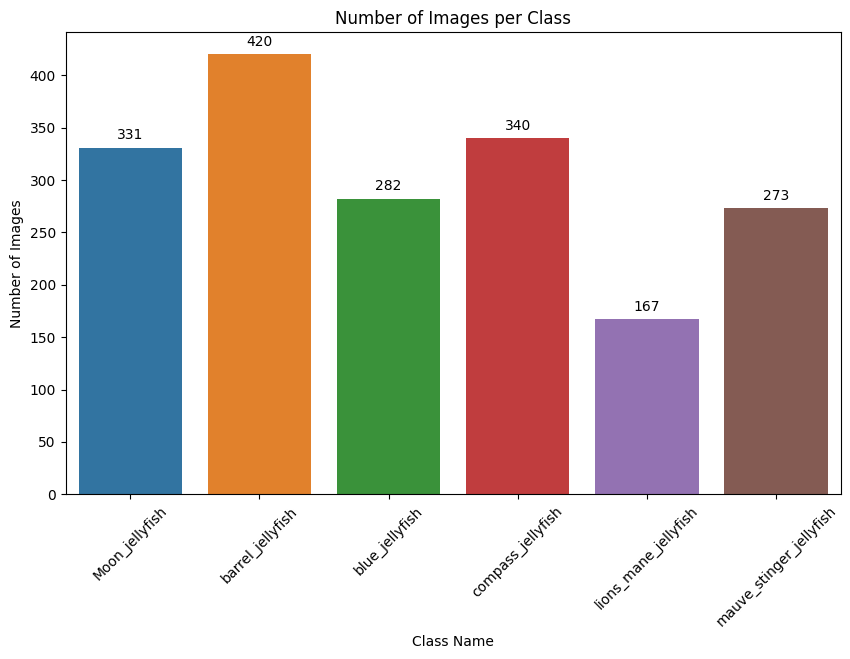

In [9]:
import pandas as pd

# 클래스별 이미지 개수 계산
class_counts = pd.Series(train_labels).value_counts().sort_index()
class_counts.index = train_classes  # 인덱스를 클래스 이름으로 변경

# 막대 그래프 그리기
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=class_counts.index, y=class_counts.values)

# 각 막대에 숫자 표시
for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points')

# 그래프 제목 및 레이블 설정
plt.title('Number of Images per Class')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)  # x축 레이블 회전
plt.show()